In [32]:
import pandas as pd
import seaborn as sns
import missingno as msno

from urllib.parse import urlparse
import matplotlib.pyplot as plt

### Действия для ga_hits

- удалить event_value (пустой), hit_type (все значения одинаковые)
- заполнить пропуски hit_time средним значением
- заполнить пропуски event_label модой
- заполнить пропуски hit_referer модой
- hit_date to datetime
- заменить выбросы на граничные значения (hit_time, hit_number)
- создать столбцы с номерами месяцев и дней, удалить hit_date
- добавить столбец domain, заменить значения с количеством меньше 1000 на other
- добавить столбцы path, query
- удалить hit_page_path

# Загрузка данных

In [2]:
step = 3
hits_df = pd.read_csv('data/ga_hits.csv', skiprows=lambda x: x % step != 0) 
# всего 15 726 470 строк 

In [3]:
hits_df.head()

,session_id,hit_date,hit_time,hit_number,hit_type,hit_referer,hit_page_path,event_category,event_action,event_label,event_value
0,885342191847998240.1640235807.1640235807,2021-12-23,796252.0,49,event,NaN,sberauto.com/cars/all/volkswagen/polo/e994838f...,quiz,quiz_show,NaN,NaN
1,6466333295973247896.1640246168.1640246168,2021-12-23,704194.0,41,event,NaN,sberauto.com/cars?utm_source_initial=youtube&u...,quiz,quiz_show,NaN,NaN
2,555009234841130092.1640256620.1640256620,2021-12-23,1013899.0,101,event,VloVXNWduHeTjUoDkjkO,sberauto.com/cars/all/kia/sorento/c38179cb?utm...,quiz,quiz_show,NaN,NaN
3,4555345648396008371.1640233907.1640233907,2021-12-23,107.0,4,event,trXmoxcphNjuYcShOXwL,sberauto.com/cars/all/nissan/qashqai/bfc21661?...,card_web,view_card,NaN,NaN
4,9063469723165129646.1640233902.1640233902,2021-12-23,68.0,3,event,uMnMdxLOIznakHyXLoMC,sberauto.com/cars/all/skoda/rapid/bf24b977?ren...,card_web,view_card,NaN,NaN


In [4]:
hits_df.shape

(5242156, 11)

# Разведочный анализ

Целевая переменная - event_action

## Data cleaning

<AxesSubplot:>

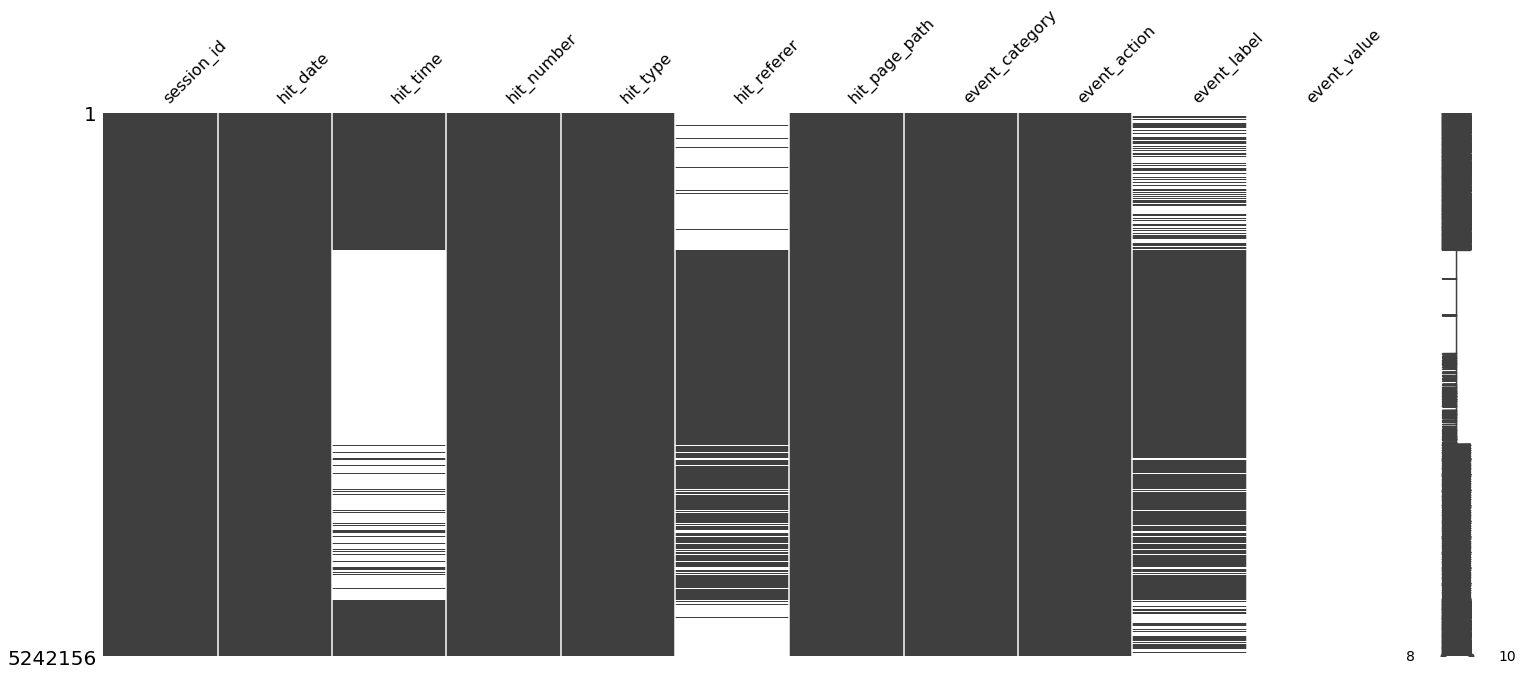

In [5]:
msno.matrix(hits_df)

In [6]:
hits_new = hits_df.copy()

In [7]:
hits_new['hit_type'].value_counts()

event    5242156
Name: hit_type, dtype: int64

In [8]:
# event_value полностью пуст, удаляем
# все значения hit_type однинаковые, удаляем

hits_new = hits_new.drop(['event_value', 'hit_type'], axis=1)

In [9]:
# процент пропущенных значений
def missing_values(df):
    return ((df.isna().sum() / len(df)) * 100).sort_values()

In [10]:
missing_values(hits_new)

session_id         0.000000
hit_date           0.000000
hit_number         0.000000
hit_page_path      0.000000
event_category     0.000000
event_action       0.000000
event_label       23.910334
hit_referer       39.903162
hit_time          58.246798
dtype: float64

### Hit_time

(array([2.135869e+06, 4.302900e+04, 6.917000e+03, 1.893000e+03,
        6.450000e+02, 2.230000e+02, 9.400000e+01, 4.900000e+01,
        3.500000e+01, 1.400000e+01]),
 array([       0. ,  1315688.3,  2631376.6,  3947064.9,  5262753.2,
         6578441.5,  7894129.8,  9209818.1, 10525506.4, 11841194.7,
        13156883. ]),
 <BarContainer object of 10 artists>)

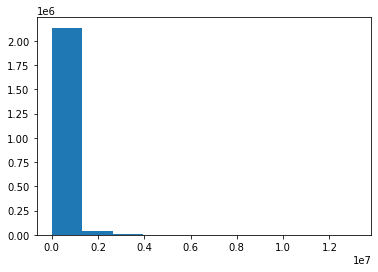

In [11]:
plt.hist(hits_new['hit_time'])

In [12]:
hits_new['hit_time'].value_counts()

0.0          13576
1.0           6117
2.0           3314
3.0           2008
4.0           1501
             ...  
486903.0         1
1153840.0        1
1466332.0        1
453430.0         1
2172865.0        1
Name: hit_time, Length: 582924, dtype: int64

In [13]:
hits_new['hit_time'].mean()

209328.07916325532

In [14]:
# заполним пропуски средним значением
hits_new['hit_time'] = hits_new['hit_time'].fillna(hits_new['hit_time'].mean())

### Event_label

In [15]:
hits_new['event_label'].value_counts()

KclpemfoHstknWHFiLit    2168454
hAHqGICPFQiPwtzubOzs     428346
OHfyUfDKdPgBdvelDlfG     208731
pzAKUYdRKNEUXxxBFUPX     119498
ghOrjqpgskpGHSFfBBsi     114090
                         ...   
aDWkTuyIexNGAQfWnDlJ          1
zdAZMCPStPvGvEsLGpUG          1
vArAYanGPQaroLUkrQQW          1
eFPwPmKhDcnlAKffPvHw          1
zCMGPrpNkfsTcYWqMUzJ          1
Name: event_label, Length: 20173, dtype: int64

In [16]:
# заполним пропуски модой
hits_new['event_label'] = hits_new['event_label'].fillna(hits_new['event_label'].mode().iloc[0])

### Hit_referer 

In [17]:
hits_new['hit_referer'].value_counts()

HbolMJUevblAbkHClEQa    2959840
FwdMTcXzWAwhtsnMAbhS      30548
sAGDBCdeVPmQPwkVEcIX      17729
GQmOLxANuSeCxCanBpMl      11790
ZeRnFrHdnMmnqraghdGJ       7672
                         ...   
BpAykXrUhrVvaLVxDsLI          1
xXkCApdVuppgaAGHtBkD          1
kGoDnujCfppPFmrbwMLF          1
CtfEJTPRMsUzvEilqSOC          1
tvGabHlPFDvTmIFiCKTL          1
Name: hit_referer, Length: 23389, dtype: int64

In [18]:
# заполним пропуски модой
hits_new['hit_referer'] = hits_new['hit_referer'].fillna(hits_new['hit_referer'].mode().iloc[0])

### Проверка

In [19]:
missing_values(hits_new)

session_id        0.0
hit_date          0.0
hit_time          0.0
hit_number        0.0
hit_referer       0.0
hit_page_path     0.0
event_category    0.0
event_action      0.0
event_label       0.0
dtype: float64

In [22]:
# сохраним получившийся датасет

hits_new.to_csv('data/ga_hits(2.0).csv', index=False)

## Приведение типов

In [3]:
hits = pd.read_csv('data/ga_hits(2.0).csv')

In [6]:
hits

,session_id,hit_date,hit_time,hit_number,hit_referer,hit_page_path,event_category,event_action,event_label
0,885342191847998240.1640235807.1640235807,2021-12-23,796252.0,49,HbolMJUevblAbkHClEQa,sberauto.com/cars/all/volkswagen/polo/e994838f...,quiz,quiz_show,KclpemfoHstknWHFiLit
1,6466333295973247896.1640246168.1640246168,2021-12-23,704194.0,41,HbolMJUevblAbkHClEQa,sberauto.com/cars?utm_source_initial=youtube&u...,quiz,quiz_show,KclpemfoHstknWHFiLit
2,555009234841130092.1640256620.1640256620,2021-12-23,1013899.0,101,VloVXNWduHeTjUoDkjkO,sberauto.com/cars/all/kia/sorento/c38179cb?utm...,quiz,quiz_show,KclpemfoHstknWHFiLit
3,4555345648396008371.1640233907.1640233907,2021-12-23,107.0,4,trXmoxcphNjuYcShOXwL,sberauto.com/cars/all/nissan/qashqai/bfc21661?...,card_web,view_card,KclpemfoHstknWHFiLit
4,9063469723165129646.1640233902.1640233902,2021-12-23,68.0,3,uMnMdxLOIznakHyXLoMC,sberauto.com/cars/all/skoda/rapid/bf24b977?ren...,card_web,view_card,KclpemfoHstknWHFiLit
...,...,...,...,...,...,...,...,...,...
5242151,5296596234193380228.1640276868.1640276868,2021-12-23,1006170.0,26,HbolMJUevblAbkHClEQa,sberauto.com/cars/all/volkswagen/polo/e994838f...,quiz,quiz_show,KclpemfoHstknWHFiLit
5242152,1752395810013978028.1640242606.1640242606,2021-12-23,738385.0,29,HbolMJUevblAbkHClEQa,sberauto.com/cars?utm_source_initial=yandex&ut...,quiz,quiz_show,KclpemfoHstknWHFiLit
5242153,788733220421394146.1640259301.1640259301,2021-12-23,601072.0,32,HbolMJUevblAbkHClEQa,sberauto.com/cars?utm_source_initial=yandex&ut...,quiz,quiz_show,KclpemfoHstknWHFiLit
5242154,2213339474111531465.1640270285.1640270285,2021-12-23,652518.0,37,HbolMJUevblAbkHClEQa,sberauto.com/cars/all/bmw/5-serii/eb5698f6?utm...,quiz,quiz_show,KclpemfoHstknWHFiLit


In [11]:
hits.dtypes

session_id                object
hit_date          datetime64[ns]
hit_time                 float64
hit_number                 int64
hit_referer               object
hit_page_path             object
event_category            object
event_action              object
event_label               object
dtype: object

In [10]:
hits['hit_date'] = pd.to_datetime(hits['hit_date'])

## Аномалии 

In [21]:
hits.head()

,session_id,hit_date,hit_time,hit_number,hit_referer,hit_page_path,event_category,event_action,event_label
0,885342191847998240.1640235807.1640235807,2021-12-23,796252.0,49,HbolMJUevblAbkHClEQa,sberauto.com/cars/all/volkswagen/polo/e994838f...,quiz,quiz_show,KclpemfoHstknWHFiLit
1,6466333295973247896.1640246168.1640246168,2021-12-23,704194.0,41,HbolMJUevblAbkHClEQa,sberauto.com/cars?utm_source_initial=youtube&u...,quiz,quiz_show,KclpemfoHstknWHFiLit
2,555009234841130092.1640256620.1640256620,2021-12-23,1013899.0,101,VloVXNWduHeTjUoDkjkO,sberauto.com/cars/all/kia/sorento/c38179cb?utm...,quiz,quiz_show,KclpemfoHstknWHFiLit
3,4555345648396008371.1640233907.1640233907,2021-12-23,107.0,4,trXmoxcphNjuYcShOXwL,sberauto.com/cars/all/nissan/qashqai/bfc21661?...,card_web,view_card,KclpemfoHstknWHFiLit
4,9063469723165129646.1640233902.1640233902,2021-12-23,68.0,3,uMnMdxLOIznakHyXLoMC,sberauto.com/cars/all/skoda/rapid/bf24b977?ren...,card_web,view_card,KclpemfoHstknWHFiLit


In [24]:
def calculate_outliers(data):
    
    q25 = data.quantile(0.25)
    q75 = data.quantile(0.75)
    iqr = q75 - q25

    boundaries = (q25 - 1.5 * iqr, q75 + 1.5 * iqr)

    return boundaries

### Hit_time

Text(0, 0.5, 'Hit_time')

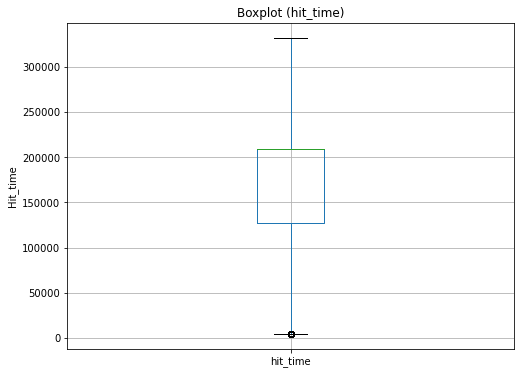

In [32]:
plt.figure(figsize=(8, 6))
hits.boxplot(column='hit_time')
plt.title('Boxplot (hit_time)')
plt.ylabel('Hit_time')

In [25]:
boundaries = calculate_outliers(hits['hit_time'])
boundaries

(4167.88125511707, 332424.1979081382)

In [29]:
# найдем выбросы в hit_time

is_outlier = (hits['hit_time'] < boundaries[0]) | (hits['hit_time'] > boundaries[1])
is_outlier.sum()

693261

In [30]:
# процент выбросов

is_outlier.sum() / len(hits)

0.13224730435339963

In [31]:
# заменим выбросы на граничные значения

hits.loc[(hits['hit_time'] < boundaries[0]), 'hit_time'] = int(boundaries[0])
hits.loc[(hits['hit_time'] > boundaries[1]), 'hit_time'] = int(boundaries[1])

### Hit_number

(array([1332763., 1062283.,  775990.,  525511.,  371151.,  269086.,
         196948.,  146357.,  110367.,  451700.]),
 array([ 1. ,  7.1, 13.2, 19.3, 25.4, 31.5, 37.6, 43.7, 49.8, 55.9, 62. ]),
 <BarContainer object of 10 artists>)

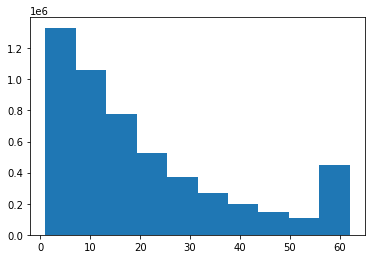

In [40]:
plt.hist(hits['hit_number'])

In [36]:
boundaries = calculate_outliers(hits['hit_number'])
boundaries

(-26.0, 62.0)

In [37]:
# найдем выбросы в hit_number

is_outlier = (hits['hit_number'] < boundaries[0]) | (hits['hit_number'] > boundaries[1])
is_outlier.sum()

354462

In [38]:
# процент выбросов

is_outlier.sum() / len(hits)

0.06761759856059224

In [39]:
# заменим выбросы на граничные значения

hits.loc[(hits['hit_number'] < boundaries[0]), 'hit_number'] = int(boundaries[0])
hits.loc[(hits['hit_number'] > boundaries[1]), 'hit_number'] = int(boundaries[1])

## Feature Engineering

In [53]:
hits.head()

,session_id,hit_time,hit_number,hit_referer,hit_page_path,event_category,event_action,event_label,month,day
0,885342191847998240.1640235807.1640235807,332424.0,49,HbolMJUevblAbkHClEQa,sberauto.com/cars/all/volkswagen/polo/e994838f...,quiz,quiz_show,KclpemfoHstknWHFiLit,12,23
1,6466333295973247896.1640246168.1640246168,332424.0,41,HbolMJUevblAbkHClEQa,sberauto.com/cars?utm_source_initial=youtube&u...,quiz,quiz_show,KclpemfoHstknWHFiLit,12,23
2,555009234841130092.1640256620.1640256620,332424.0,62,VloVXNWduHeTjUoDkjkO,sberauto.com/cars/all/kia/sorento/c38179cb?utm...,quiz,quiz_show,KclpemfoHstknWHFiLit,12,23
3,4555345648396008371.1640233907.1640233907,4167.0,4,trXmoxcphNjuYcShOXwL,sberauto.com/cars/all/nissan/qashqai/bfc21661?...,card_web,view_card,KclpemfoHstknWHFiLit,12,23
4,9063469723165129646.1640233902.1640233902,4167.0,3,uMnMdxLOIznakHyXLoMC,sberauto.com/cars/all/skoda/rapid/bf24b977?ren...,card_web,view_card,KclpemfoHstknWHFiLit,12,23


### Hit_date

In [42]:
hits['hit_date'].dt.year.value_counts()

2021    5242156
Name: hit_date, dtype: int64

In [43]:
hits['hit_date'].dt.month.value_counts()

12    1122562
10     780738
11     770024
9      720651
6      520005
8      464318
5      447198
7      416660
Name: hit_date, dtype: int64

In [44]:
hits['hit_date'].dt.day.value_counts()

24    345229
29    226782
25    225512
21    218074
30    208128
26    195021
28    194152
23    190785
22    186980
27    181951
14    176211
17    165486
19    163148
16    161857
18    158856
15    156751
13    154902
12    149817
6     148437
20    147312
7     143821
1     143003
5     141800
9     139199
11    139117
8     138582
10    135785
3     133876
2     132324
4     122439
31    116819
Name: hit_date, dtype: int64

In [45]:
# создадим столбцы с номерами месяцев и дней

hits['month'] = hits['hit_date'].dt.month
hits['day'] = hits['hit_date'].dt.day

In [50]:
# удалим исходный столбец

hits = hits.drop(['hit_date'], axis=1)

### Hit_page_path

In [34]:
hits['hit_page_path']

0          sberauto.com/cars/all/volkswagen/polo/e994838f...
1          sberauto.com/cars?utm_source_initial=youtube&u...
2          sberauto.com/cars/all/kia/sorento/c38179cb?utm...
3          sberauto.com/cars/all/nissan/qashqai/bfc21661?...
4          sberauto.com/cars/all/skoda/rapid/bf24b977?ren...
                                 ...                        
5242151    sberauto.com/cars/all/volkswagen/polo/e994838f...
5242152    sberauto.com/cars?utm_source_initial=yandex&ut...
5242153    sberauto.com/cars?utm_source_initial=yandex&ut...
5242154    sberauto.com/cars/all/bmw/5-serii/eb5698f6?utm...
5242155    sberauto.com/cars/all/toyota/alphard/2ebe4871?...
Name: hit_page_path, Length: 5242156, dtype: object

In [35]:
# проверим, все ли строки начинаются с sberauto.com

hits[~hits['hit_page_path'].str.startswith('sberauto.com')]['hit_page_path']

6          client.saptest.sberauto-team.com/cars/all/merc...
22          podpiska.sberauto.com/?yclid=7645190563903103343
61          podpiska.sberauto.com/?yclid=7650868345829907007
222         podpiska.sberauto.com/?yclid=7646255195212803653
500        client.sap.sberauto-team.com/cars/all/volkswag...
                                 ...                        
5241663                            podpiska.sberauto.com/faq
5242117    podpiska.sberauto.com/?yzclid=7169385180044596044
5242118    podpiska.sberauto.com/?yzclid=7837953414087936832
5242119    podpiska.sberauto.com/?yzclid=5888433221627265513
5242140                            podpiska.sberauto.com/faq
Name: hit_page_path, Length: 1100264, dtype: object

In [42]:
# добавим столбец с доменами

hits['domain'] = hits['hit_page_path'].apply(lambda x: x.split('/')[0])

In [45]:
hits['domain'].value_counts()

sberauto.com                        4141892
podpiska.sberauto.com               1058020
                                      20265
client.saptest.sberauto-team.com      12758
other                                  2521
client.sap.sberauto-team.com           2501
localhost                              1543
client.preprod.sberauto.com            1377
sberauto-client.sap.sberauto.com       1279
Name: domain, dtype: int64

In [44]:
# Заменим значения с количеством меньше 1000 на other

values = hits['domain'].value_counts()
hits['domain'] = hits['domain'].apply(lambda x: 'other' if values[x] < 1000 else x)

In [46]:
# удалим из hit_page_path части из domain

hits['hit_page_path'] = hits['hit_page_path'].str.split('/', 1).str[1]

In [51]:
# рассмотрим остальные составляющие url

parsed_url = urlparse(hits['hit_page_path'][88])

print("Scheme:", parsed_url.scheme)
print("Netloc:", parsed_url.netloc)
print("Path:", parsed_url.path)
print("Query:", parsed_url.query)

Scheme: 
Netloc: 
Path: cars/all/renault/logan/8c3c73f2
Query: rental_page=rental_car&fbclid=paaabxaph9gy1ickwddkjw3g08an245pkki8rdvblvglj8qeokw878lmczirw_aem_at9wezv4jecw39iansyvloefeseer0rkz_yxf6xdr7suktiimukjgbl_etzib0k_skbxjqgjkbk3cupavtoy3vxqel3qc5h-re4hutlsyqxdggk-uozbotk-1oruljvgyi4


In [52]:
# добавим два столбца: path, query

hits['path'] = hits['hit_page_path'].apply(lambda x: urlparse(x).path)
hits['query'] = hits['hit_page_path'].apply(lambda x: urlparse(x).query)

In [55]:
hits = hits.drop(['hit_page_path'], axis=1)

In [56]:
hits.to_csv('data/ga_hits(2.1).csv', index=False)